In [1]:
import numpy as np
import mne
from mne import preprocessing

from scipy import signal

import matplotlib.pyplot as plt
from tfld import utils

import pyxdf

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd

from joblib import delayed, Parallel
from tfld import tfld

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


%load_ext autoreload
%autoreload 2

In [2]:
channels = np.array(['fp1', 'fp2', 'f3', 'f4', 'c3', 'c4', 'p3', 'p4', 'o1', 'o2',
           'f7', 'f8', 't7', 't8', 'p7', 'p8', 'fz', 'cz', 'pz', 'm1', 'm2', 'afz', 'cpz', 'poz'])
frontal_channels = np.array([i for i, c in enumerate(channels) if 'f' in c])
print(frontal_channels, channels[frontal_channels])

[ 0  1  2  3 10 11 16 21] ['fp1' 'fp2' 'f3' 'f4' 'f7' 'f8' 'fz' 'afz']


In [3]:
def get_matb_data_by_session(dir_, subject_list, session_list):
    eeg_by_subject_by_session = []
    labels_by_subject_by_session = []
    for i, sub in enumerate(subject_list):
        eeg_by_subject_by_session.append([])
        labels_by_subject_by_session.append([])
        for j, sess in enumerate(session_list):
            eeg_by_subject_by_session[-1].append([])
            labels_by_subject_by_session[-1].append([])
            f = dir_ + 'sub%s_preprocessed/segmented_session%s/'%(sub, sess)

            for k, mat_file in enumerate(np.sort(os.listdir(f))):
                mat = scipy.io.loadmat(f + mat_file)

                eeg_by_subject_by_session[-1][-1].append(mat['EEGData'])
                labels_by_subject_by_session[-1][-1].append(int(mat['difficulty']))
            eeg_by_subject_by_session[-1][-1] = np.array(eeg_by_subject_by_session[-1][-1])
            labels_by_subject_by_session[-1][-1] = np.array(labels_by_subject_by_session[-1][-1])
                
    return eeg_by_subject_by_session, labels_by_subject_by_session

def get_matb_data_by_participant(dir_, subject_list):
    eeg_by_subject_by_session, labels_by_subject_by_session = get_matb_data_by_session(dir_, subject_list)
    
    windowed_by_subject = [np.concatenate((eeg_by_subject_by_session[i][0], eeg_by_subject_by_session[i][1])) for i in range(len(subject_list))]
    labels_by_subject = [np.concatenate((labels_by_subject_by_session[i][0], labels_by_subject_by_session[i][1])) for i in range(len(subject_list))]
    
    return windowed_by_subject, labels_by_subject

In [4]:
import scipy.io
import os

dir_ = '/mnt/matb-data/preprocessed/'

first_digit = [str(i) for i in range(5)]
second_digit = [str(i) for i in range(10)]

subjects = []
for i in first_digit:
    for j in second_digit:
        if i == '0' and j == '0':
            continue
        subjects.append(i + j)
        
subjects.append('50')

session_list = ['1', '2']

data = get_matb_data_by_session(dir_, subjects, session_list)

In [5]:
from sklearn.metrics import balanced_accuracy_score as bas
from libci.methods import TStoSegmenttoBFtoVec as T1
from tqdm import tqdm

X = []
y = []

n_subjects=50
n_sessions=2

n_segments=1
sfreq=500
bands=[[4,7], [8,12], [13,20]]

for i in tqdm(range(n_subjects)):
    for j in range(n_sessions):
        X.append(T1(n_segments=1, sfreq=500, bands=bands, pca_components=None, pca_n_elbows=None).fit_transform(data[0][i][j][:, frontal_channels]))
        y.append(data[1][i][j])    

y = [(t < 2).astype(int) for t in y]

2023-02-08 21:06:53.705618: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 21:06:53.710254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 21:06:53.710273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


In [15]:
from sklearn.metrics import balanced_accuracy_score as bas
from scipy.linalg import polar

def matb_experiment(X, y, p, grid=0.1, n_samples_to_estimate_risk=100, acorn=None):
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    if acorn is not None:
        np.random.seed(acorn)
        
    assert len(X) == len(y)
    n_tasks = len(X)
            
    train_inds = [tfld.even_sample_inds(y_, p=1, continuous=True) for y_ in y]
    scalers = [tfld.TranslateStandardScale().fit(X[i][train_inds[i]], y[i][train_inds[i]]) for i in range(n_tasks)]
    
    projections = []
    covs = []
    for i in range(n_tasks):
        X_ = scalers[i].transform(X[i])
        fld= tfld.FLD()
        fld.fit(X_[train_inds[i]], y[i][train_inds[i]])
                
        covs.append(fld.cov_)
        projections.append(fld.projection_)
        
    
    accuracies = np.zeros((n_tasks, 5))
    alphas = np.zeros((n_tasks, 2))
    for i in range(n_tasks):
        if i % 2 == 0:
            cross_session_index=i+1
        else:
            cross_session_index=i-1
            
        cross_session_vector = projections[cross_session_index]
                        
        train_inds = tfld.even_sample_inds(y[i], p=p, continuous=True)
        scaler = tfld.TranslateStandardScale().fit(X[i][train_inds], y[i][train_inds])
        
        X_ = scaler.transform(X[i])
        fld = tfld.FLD().fit(X_[train_inds], y[i][train_inds])
        target_vector = fld.projection_
        pooled_cov = fld.cov_
        class_1_mean = fld.means_[1]
    
    
        #- average-source projection vector
        indices_to_include = np.array([j for j in range(n_tasks) if j not in [i, cross_session_index]])
        source_projs = [projections[j] for j in indices_to_include]
        average_source_vector = tfld.estimate_mu(source_projs)

                                
        optimal_alpha = tfld.get_optimal_alpha(len(train_inds), class_1_mean, source_projs, 
                                               grid, n_samples_to_estimate_risk=n_samples_to_estimate_risk, 
                                               cov=pooled_cov, variance_from_target=None, variance_from_combined=None)
        optimal_proj = optimal_alpha * target_vector + (1 - optimal_alpha) * average_source_vector
        alphas[i,0] = optimal_alpha
        
        #- oracle projection vector
        test = [j for j in range(len(X[i])) if j not in train_inds]
        
        oracle_alpha = utils.get_oracle_alpha(X_[test], y[i][test], target_vector, average_source_vector, h=grid)
        oracle_proj = oracle_alpha * target_vector + (1 - oracle_alpha) * average_source_vector
        alphas[i,1] = oracle_alpha
        
        #- Evaluation
        pred = (X_[test] @ target_vector >= 0).astype(int)
        accuracies[i, 0] = bas(y[i][test], pred)
    
        pred = (X_[test] @ average_source_vector >= 0).astype(int)
        accuracies[i, 1] = bas(y[i][test], pred)
        
        pred = (X_[test] @ optimal_proj >= 0).astype(int)
        accuracies[i, 2] = bas(y[i][test], pred)
        
        pred = (X_[test] @ oracle_proj >= 0).astype(int)
        accuracies[i, 3] = bas(y[i][test], pred)
        
        random_accuracies = np.zeros(100)
        for j in range(100):
            random_alpha = np.random.choice(np.arange(0,1+grid, grid), size=1)[0]
            random_proj = random_alpha * target_vector + (1 - random_alpha) * average_source_vector
            pred = (X_[test] @ random_proj >= 0).astype(int)
            random_accuracies[j] = bas(y[i][test], pred)
            
        accuracies[i, 4] = np.mean(random_accuracies)
    
    return accuracies, alphas

In [50]:
from joblib import Parallel, delayed
from tfld import tfld

np.random.seed(1)

n_mc = 100
n_jobs=30
p_list = [0.05, 0.1, 0.2, 0.5]

accuracies = np.zeros((len(p_list), n_mc, len(X), 5))
alphas = np.zeros((len(p_list), n_mc, len(X), 2))
for i, p in enumerate(tqdm(p_list)):
    f = lambda x: matb_experiment(X, y, p, grid=0.1)
    
    results = Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))
    
    for j, (accuracy, alpha) in enumerate(results):
        accuracies[i,j] = accuracy
        alphas[i,j] = alpha
    
    print(i, np.mean(np.mean(accuracies, axis=1), axis=1)[i])

 25%|█████████████████████                                                               | 1/4 [02:15<06:46, 135.61s/it]

0 [0.58739239 0.68265703 0.67443121 0.70605415 0.65335168]


 50%|██████████████████████████████████████████                                          | 2/4 [04:30<04:30, 135.21s/it]

1 [0.61058906 0.68520038 0.68396365 0.71271787 0.67179591]


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [06:42<02:13, 133.92s/it]

2 [0.66237064 0.68784759 0.69445819 0.72728695 0.69236208]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:53<00:00, 133.45s/it]

3 [0.70604866 0.6914685  0.71502369 0.74724908 0.71129976]


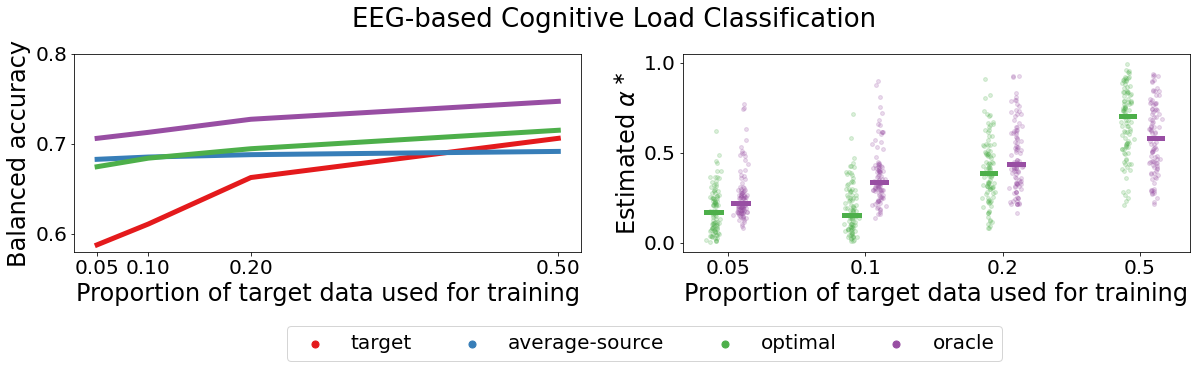

In [58]:
import seaborn as sns

mean_accuracies = np.mean(np.mean(accuracies, axis=1), axis=1)
std_accuracies = np.std(np.mean(accuracies, axis=1), axis=1) / np.sqrt((n_mc * len(X)))

fig, ax = plt.subplots(1,2, figsize=(20,5))

algos = ['target', 'average-source', 'optimal', 'oracle', 'random']
colors = sns.color_palette("Set1", n_colors=len(algos)+1)

fontsize=24
labelsize=20
for i, mean in enumerate(mean_accuracies.T[:-1]):
    ax[0].plot(p_list, mean, color=colors[i], lw=5)

xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

for i, algo in enumerate(algos[:-1]):
    ax[0].scatter(-1,-1, label=algos[i], color=colors[i], s=50)
    

ax[0].set_ylim(*ylim)
ax[0].set_xlim(*xlim)

ax[0].set_ylabel('Balanced accuracy', fontsize=fontsize)
ax[0].set_xlabel('Proportion of target data used for training', fontsize=fontsize)
ax[0].set_xticks(p_list)
ax[0].tick_params(labelsize=labelsize)
ax[0].set_yticks([0.6, 0.7, 0.8])


mean_alphas = np.mean(alphas, axis=1)
for i, means in enumerate(mean_alphas):
    temp_norms = np.random.normal(i, 0.02, size=len(X))
    
    optimals = means[:, 0]
    oracles = means[:, 1]
    
    ax[1].scatter(temp_norms - 0.1, optimals, s=15, alpha=0.2, color=colors[2])
    ax[1].scatter(temp_norms + 0.1, oracles, s=15, alpha=0.2, color=colors[3])
        

    ax[1].plot(np.sort(temp_norms) - 0.1, len(X) * [np.median(optimals)], lw=5, color=colors[2])
    ax[1].plot(np.sort(temp_norms) + 0.1, len(X) * [np.median(oracles)], lw=5, color=colors[3])
    
ax[1].scatter(-1,-1, s=20, alpha=1, color=colors[2], label='optimal')
ax[1].scatter(-1,-1, s=20, alpha=1, color=colors[3], label='oracle')

ax[1].set_ylim(-0.05, 1.05)
ax[1].set_xlim(-0.33)

ax[1].set_ylabel(r'Estimated $\alpha^\ast$', fontsize=fontsize)
ax[1].set_xlabel('Proportion of target data used for training', fontsize=fontsize)
ax[1].tick_params(labelsize=labelsize)
    
ax[1].set_xticks(np.arange(len(p_list)), p_list)

fig.suptitle('EEG-based Cognitive Load Classification', fontsize=fontsize+2)
plt.subplots_adjust(bottom=0.3, top=0.85)
ax[0].legend(fontsize=20, loc='lower left', ncol=4, bbox_to_anchor=(0.4, -0.6, 0.1, 0.2))

plt.savefig('matb_cognitive_load_bas_and_alphas.pdf', bbox_inches="tight")

0.05 92 0.19210909797445053
0.1 92 0.19230459435112035
0.2 81 0.1205753246753245
0.5 76 0.08336385836385818


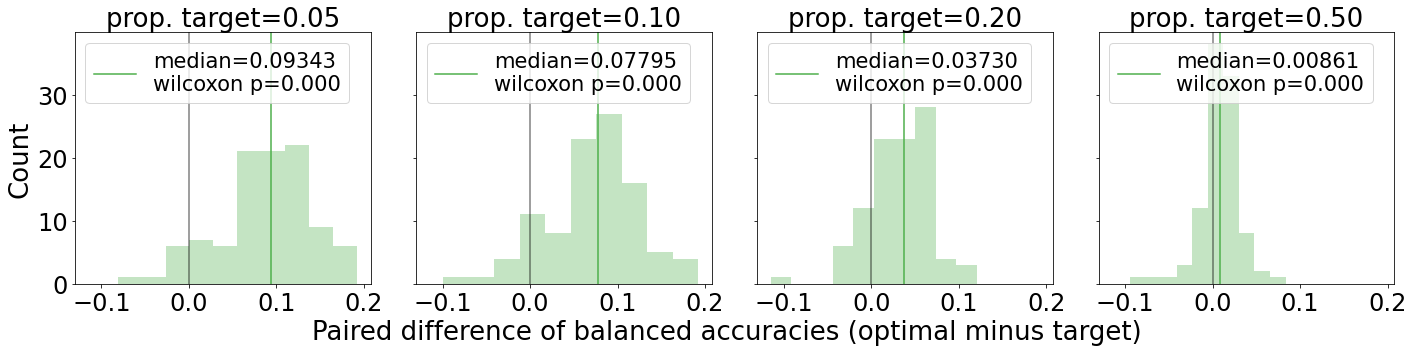

In [55]:
from scipy.stats import wilcoxon

fig, axes = plt.subplots(1, len(p_list), figsize=(20,5), sharex=True, sharey=True)
optimal_minus_in_task = np.mean(accuracies, axis=1)[:,:, 2] - np.mean(accuracies, axis=1)[:, :, 0]


for i, ax in enumerate(axes):
    temp = optimal_minus_in_task[i]
    mean = np.median(temp)
    print(p_list[i], np.sum(temp > 0), np.max(temp))
    T, p_ = wilcoxon(temp, alternative='greater')
    
    ax.hist(temp, alpha=0.33, color=colors[2])
    ax.set_title('prop. target=%1.2f'%(p_list[i]), fontsize=26)
        
    ax.axvline(x=mean, label='median=%1.5f\nwilcoxon p=%1.3f'%(mean, p_), color=colors[2])
    ax.axvline(x=0, c='k', alpha=0.5)
    
    ax.legend(fontsize=21, loc='upper left')
    ax.tick_params(labelsize=24)

    
axes[0].set_ylabel('Count', fontsize=26)
axes[1].set_xlabel('Paired difference of balanced accuracies (optimal minus target)', x=1.05, fontsize=26)

plt.tight_layout()
plt.savefig('cognitive_load_histograms.pdf')

In [56]:
np.random.seed(1)

n_tasks=len(X)

n_mc=10
kappas = np.zeros(n_mc)

for j in range(n_mc):
    train_inds = [tfld.even_sample_inds(y_, p=1, continuous=True) for y_ in y]

    scalers = [tfld.TranslateStandardScale().fit(X[i][train_inds[i]], y[i][train_inds[i]]) for i in range(n_tasks)]

    projections = []
    covs = []
    for i in range(n_tasks):
        X_ = scalers[i].transform(X[i])
        fld = tfld.FLD().fit(X_[train_inds[i]], y[i][train_inds[i]])
        target_vector = fld.projection_
        projections.append(target_vector)

    kappa = tfld.estimate_kappa(projections)
    kappas[j] = kappa
    
print(np.mean(kappas))

17.21574537739543


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


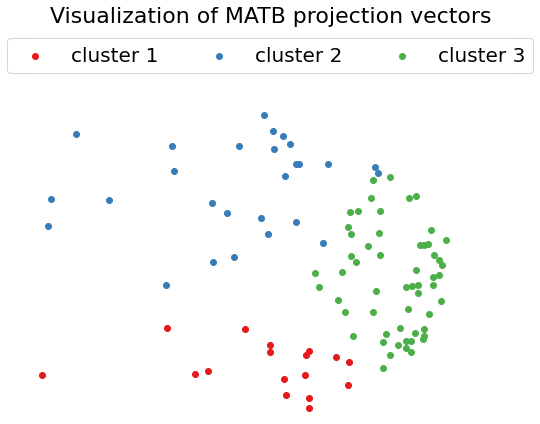

In [49]:
import seaborn as sns
from graspologic.cluster import GaussianCluster as GMM
from graspologic.embed import AdjacencySpectralEmbed as ASE

np.random.seed(1)

fig, ax=plt.subplots(1,1, figsize=(8,6))

colors=sns.color_palette("Set1", n_colors=8)
# colors = [colors[4], colors[6], colors[7]]



affinity_matrix = np.zeros((n_tasks, n_tasks))
for i in range(n_tasks):
    for j in range(n_tasks):
        if i == j:
            affinity_matrix[i,j]=0
        else:
            affinity_matrix[i,j]= (np.dot(projections[i], projections[j]) + 1) / 2
            
ase = ASE(n_components=2).fit_transform(affinity_matrix)
gmm = GMM(min_components=1, max_components=8, reg_covar=1e-5).fit(np.array(ase))
gmm_labels = gmm.predict(ase)

for i, a in enumerate(ase):
    temp_label = gmm_labels[i]
    ind = np.where(np.unique(gmm_labels) == temp_label)[0][0]
    
    if ind >=5:
        color=colors[ind+1]
    else:
        color=colors[ind]
    
    ax.scatter(*a, color=color)
    
for i,c in enumerate(np.unique(gmm_labels)):
    if i >=5:
        color=colors[i+1]
    else:
        color=colors[i]
    
    ax.scatter(-2,-2, c=color, label=f'cluster {i+1}')
    
ax.set_xlim(0.45,1)
ax.set_ylim(-0.6,1)
    
ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(ncol=3, fontsize=20,loc='upper center')

ax.set_title('Visualization of MATB projection vectors', fontsize=22)

ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('matb-projection-vectors-clustered.pdf')